![](pic1.png)

## Section 1: Quantity Estimation

### Dataset

Sales of two generic cigarettes across 488 stores were recorded for 2 weeks. Each cigarette is tracked through two IDs across independent stores, one for sale of a single-pack and one for sale of a multi-pack. 

#### Transaction Level Data 

<table align = "left">
    <tr>
        <th>product_ean</th>
        <th>store_id</th>
        <th>sales_receipt</th>
        <th>sales_pieces</th>
        <th>sales_turnover_gross</th>
    </tr>
    <tr>
        <th>Product ID</th>
        <th>Store ID</th>
        <th>Receipt ID</th>
        <th>No. Units transacted</th>
        <th>Total sales value,<br>
        denoted in Indonesian 
        Rupiah</th>
    </tr>
</table>

#### Product Master Data

<table align = "left">
    <tr>
        <th>product_ean</th>
        <th>product_name</th>
        <th>Is_multipack</th>
    </tr>
    <tr >
        <th>Product ID</th>
        <th>Generic Name of cigaratte</th>
        <th>Boolean flag to denote larger pack size</th>
    </tr>
</table>



## Requirement 

1. Investigate data quality problems within the transactional dataset and propose generalisable, scalable methods to manage identified isues.

In [2]:
# import relevant libraries for EDA 

import pandas as pd
import numpy as np
import os 
import math

### Issues Found

1. Records with duplicates (at time more than 1 duplicate)
2. Dtype of sales_date_id 
3. Upon close inspection of the pair (sales_receipt and sales_date_id), we find that the number of unique pairs does not equal to the total number of records in our data frame. Hence there is a possibility that the receipt contains two purchases, each for different pack of ciggaratte
4. non multipack has partial sales which is not possible


With the above requirements, create a function to process the data

In [5]:
def preprocess(path = os.getcwd(), remove_duplicates = True, select_data = True, check_period = True,
              check_partial_sales = True):
    """
    entire process of reading in data frame from file directory,
    pre-processing, and data mutation
    
    path : path where data is located
    
    remove_duplicates : if True then only first entry for duplicate rows (entire row) will remain
    
    select_data : if path has more than the two desired csv files, transaction data and product dimensions,
    user will be prompted to select the data
    
    check_period : if true, will print start and end date of the data
    
    check_partial_sales : if true, will print out store ids with partial sales if any, partial sales refer to floating
    point numbers
    """
    data = {x.split('.csv')[0]:x for x in os.listdir() if '.csv' in x}
    names = list(data.keys())
    if select_data:
        for i in range(len(names)):
            print(names[i], ' : ' ,i + 1)
        print()
        transaction_data = input('Please key in the transaction file number from the list above: ')
        transaction_data = names[int(transaction_data)-1]
        for i in range(len(names)):
            if names[i] == transaction_data:
                continue
            else:
                print(names[i], ' : ',i + 1)
        print()
        dimension_data = input('Please key in the dimension file number from the above list: ' )
        dimension_data = names[int(dimension_data)-1]
    else:    
        if 'transaction' in names[0]:
            transaction_data = names[0]
            dimension_data = names[1]
        else:
            transaction_data = names[1]
            dimension_data = names[0]
    
    def join_data(name1, name2, remove_duplicates, check_period, check_partial_sales):
        """
        name1 : transaction data
        name2 : dimension data
        """
        print("Creating data frame\n")
        df1 = pd.DataFrame(pd.read_csv(data[name1]))
        df2 = pd.DataFrame(pd.read_csv(data[name2]))
        if remove_duplicates:
            df1 = df1.drop_duplicates().copy()        
        df1.loc[:, 'sales_date_id'] = pd.to_datetime(df1.loc[:,'sales_date_id'], format = '%Y%m%d').copy()
        if check_period:
            print("Earliest date recorded is {}, latest date recorded is {}.".format(min(df1['sales_date_id']),max(df1['sales_date_id'])))
            print()
        maindf1 = df1.join(df2.set_index('product_ean'), how = 'inner',on='product_ean')
        maindf1['sales_receipt_has_duplicate'] = maindf1.duplicated(subset = 'sales_receipt', keep = False) # set bool column
        if check_partial_sales:
            partial_sales_stores = maindf1.loc[(maindf1['sales_pieces'] % maindf1['sales_pieces'].apply(
            lambda x :math.floor(x) if x > 1 else 1) != 0)]['store_id'].unique().tolist()
            print("List of stores with partial sales: ", partial_sales_stores)
            print()
        maindf1.loc[:,'product_name'] = maindf1['product_name'].apply(lambda x: x.strip())
        temp_index_ls = maindf1.loc[(maindf1['is_multipack'] == 0) & (maindf1['sales_pieces'] % maindf1['sales_pieces'].apply(
            lambda x :math.floor(x) if x > 1 else 1) != 0)].index.to_list()
        maindf1 = maindf1.loc[~maindf1.index.isin(temp_index_ls)].copy() # remove partial sales from non multipack cigarettes

        print("=" * len("Data Frame Created"))
        print("Data Frame Created")
        print("=" * len("Data Frame Created"))
        return maindf1

    return join_data(transaction_data, dimension_data, remove_duplicates, check_period, check_partial_sales)
    
    
    
    

In [6]:
maindf = preprocess(select_data=False)

Creating data frame

Earliest date recorded is 2019-12-01 00:00:00, latest date recorded is 2019-12-15 00:00:00.

List of stores with partial sales:  [16153, 143, 16154, 655, 17840]

Data Frame Created







===========================================================================================================================

## Requirement 
2. Estimate the total number of units sold across the time period for each cigarette. Applications are examined based on the quality of considerations that was given to the estimation process

In [10]:
# target variable
maindf.loc[:,('sales_pieces', 'product_name','is_multipack')].groupby(
    by = ['product_name', 'is_multipack']).sum()

sales_pieces
product_name is_multipack              
Cigg A       0                  56713.0
             1                  16738.5
Cigg B       0                  27010.0
             1                   8075.5

In [19]:
maindf1 = maindf.copy()

#### Methodology

- In order to estimate the number of units sold for each ciggerate type. We will first find the sample mean price per unit of ciggarete for each type of cigg. We store this under the series mean price per unit.
- We will then weight the sample mean by the std dev(price) of each store, the assumption is that the larger the std dev, the higher the penalty  
- The estimate is given by, 
$$\frac{1}{n}\sum_{k=1}^n \frac{mean(price_k) - std(price_k)^{penalty}} {mean(price_k)}$$

Where n is the number of shops selling that particular ciggarette and penalty is a prior constant

##### Assumptions
- Assume that a multipack contains 10 packs of cigg

In [20]:
def total_pieces(series):
    """
    apply helper function to get the total number of pieces in each transaction
    
    the number 10 is based on our assumption of number of ciggs in one multipack
    """
    return series[0]*10 if series[1] == 1 else series[0]

In [21]:
# creat col for price_per_unit
maindf1['price_per_unit'] = maindf1['sales_turnover_gross']/(maindf1.loc[:,('sales_pieces','is_multipack')].apply(
    total_pieces, axis = 1))

In [22]:
# create col for total_pieces
maindf1['total_pieces'] = maindf1.loc[:,('sales_pieces','is_multipack')].apply(
    total_pieces, axis = 1)

In [23]:
maindf1

,product_ean,sales_pieces,sales_turnover_gross,store_id,sales_date_id,sales_receipt,product_name,is_multipack,sales_receipt_has_duplicate,price_per_unit,total_pieces
0,9096004,3.0,65700.0,64,2019-12-01,110342232,Cigg A,0,False,21900.0,3.0
1,9096004,2.0,43800.0,64,2019-12-05,111790500,Cigg A,0,False,21900.0,2.0
2,9096004,1.0,21900.0,64,2019-12-05,111839706,Cigg A,0,False,21900.0,1.0
3,9096004,3.0,65700.0,64,2019-12-04,111004662,Cigg A,0,False,21900.0,3.0
4,9096004,1.0,21900.0,64,2019-12-04,110997769,Cigg A,0,False,21900.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
56401,9811026,1.0,216000.0,18113,2019-12-05,111653970,Cigg B,1,False,21600.0,10.0
56402,9811026,1.0,216000.0,18113,2019-12-05,111606329,Cigg B,1,True,21600.0,10.0
56403,9811026,1.0,216000.0,18113,2019-12-02,110366546,Cigg B,1,False,21600.0,10.0
56404,9811026,5.0,1080000.0,18113,2019-12-02,110471522,Cigg B,1,False,21600.0,50.0


In [86]:
def estimate(dataframe = maindf1, penalty = 1):
    """
    returns a dict of prices
    """
    
    ciggs = ('Cigg A', 'Cigg B')
    results = {}
    
    def after_penalty(series):
        score = series[1]
        if series[0] > 0: # apply the penalty
            if series[0] ** penalty > series[1]: # std more than mean
                score = 0 # exclude from the series
            else:
                score = series[1] * ((series[1]-series[0]**penalty)/series[1])
        return score


    def summation(ls1):
        total = 0
        counter = 0
        for price in ls1:
            if price == 0:
                continue
            else:
                total += price
                counter += 1
        return total/counter
    
    
    for cigg in ciggs:
        grouped1 = dataframe.loc[dataframe['product_name'] == cigg, ('store_id', 'price_per_unit')].groupby('store_id')
        grouped1.agg(['std', 'mean']).sort_values(by = ('price_per_unit','mean'))
        cigg_list = list(grouped1.agg(['std', 'mean']).sort_values(by = ('price_per_unit','mean')).apply(
            after_penalty, axis = 1).values)
        results[cigg] = summation(cigg_list)
    
    return results

In [87]:
# get the estimated price per unit for each cigg

prices = estimate()

In [88]:
prices

{'Cigg A': 19436.616173057497, 'Cigg B': 21677.97175821097}

#### To get the total number of sales unit, we take the gross sales for each cigg and divide it by the estimated price of each cigg

In [89]:
def estimate_sales(dataframe = maindf1, prices = prices):
    sales = {}
    for k,v in prices.items():    
        tempdf = dataframe.loc[maindf1['product_name'] == k, 'sales_turnover_gross']
        total_sales = tempdf.sum()
        
        sales[k] = round(total_sales/v,0)
    return sales
        

In [90]:
sales = estimate_sales()

In [91]:
sales

{'Cigg A': 142649.0, 'Cigg B': 60093.0}

#### Summary of results, error analysis

In [92]:
product_name = ['Cigg A', 'Cigg B']
total_pieces = [224098.0,107765.0]
estimated_total_pieces = [142649.0,60093.0]

summarydf = pd.DataFrame(zip(product_name, total_pieces,estimated_total_pieces), columns = ['product_name',
                                                                                           'total_pieces',
                                                                                           'estimated_total_pieces'])
summarydf.set_index('product_name')
summarydf['error'] = summarydf.apply(lambda x: abs(x[1] - x[2]), axis = 1)
summarydf #show

,product_name,total_pieces,estimated_total_pieces,error
0,Cigg A,224098.0,142649.0,81449.0
1,Cigg B,107765.0,60093.0,47672.0


# Section 2: Shopper Analytics - Customer Segmentation & Category Associations

- Dataset

#### Transaction Level Data 

<table align = "left">
    <tr>
        <th>sales_receipt</th>
        <th>sales_customer</th>
        <th>sales_product</th>
        <th>sales_date_id</th>
    </tr>
    <tr>
        <th>Receipt ID</th>
        <th>Customer ID</th>
        <th>Product ID</th>
        <th>Date ID</th>
    </tr>
</table>

#### Product Master Data

<table align = "left">
    <tr>
        <th>product_id</th>
        <th>product_lvl1_cat_desc</th>
        <th>product_lvl2_cat_desc</th>
    </tr>
    <tr >
        <th>Product ID</th>
        <th>Category Level 1</th>
        <th>Category Level 2</th>
    </tr>
</table>



## Requirement

1. Arrange customers into mutually exclusive groups and describe the customers clusters. Code libraries are allowed for this section of the code

In [93]:
# imports 
import pandas as pd
import os
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np

%matplotlib inline

In [94]:
df1 = pd.DataFrame(pd.read_csv('s2_transaction_data.csv'))
df2 = pd.DataFrame(pd.read_csv('s2_product_master.csv'))
df1 = df1.drop(columns = df1.columns[0])
# change dtype
df1.loc[:, 'sales_date_id'] = pd.to_datetime(df1.loc[:,'sales_date_id'], format = '%Y%m%d').copy()
df2 = df2.drop(columns = df2.columns[0])
# join
maindf1 = df1.join(df2.set_index('product_id'), how = 'inner',on='sales_product')

In [95]:
maindf1

,sales_receipt,sales_customer,sales_product,sales_date_id,product_lvl1_cat_desc,product_lvl2_cat_desc
0,203722145,569,30763,2018-01-02,FoodCommodity,JarredFood
5519,203960181,358,30763,2018-02-01,FoodCommodity,JarredFood
9015,204115623,358,30763,2018-02-22,FoodCommodity,JarredFood
10543,204158417,569,30763,2018-02-28,FoodCommodity,JarredFood
10832,204168017,358,30763,2018-03-01,FoodCommodity,JarredFood
...,...,...,...,...,...,...
49943,205774052,358,232498,2018-09-14,BabyAndChild,BabyPersonal
49960,205774491,11,121742,2018-09-14,Frozen,Desserts
49961,205774491,11,121743,2018-09-14,Frozen,Desserts
49977,205776025,396,176415,2018-09-14,FoodCommodity,CookingSaucesAndKits


In [96]:
maindf1 = maindf1.loc[:, ['sales_customer', 'sales_receipt','sales_product']]

In [97]:
maindf1

,sales_customer,sales_receipt,sales_product
0,569,203722145,30763
5519,358,203960181,30763
9015,358,204115623,30763
10543,569,204158417,30763
10832,358,204168017,30763
...,...,...,...
49943,358,205774052,232498
49960,11,205774491,121742
49961,11,205774491,121743
49977,396,205776025,176415


In [100]:
maindf2 = maindf1.groupby(by='sales_customer').agg({'sales_receipt':'nunique', 'sales_product':'count'}).rename(
    columns = {'sales_receipt':'frequency_visits','sales_product': 'total_purchase'})
maindf2

,frequency_visits,total_purchase
sales_customer,,
1,1,24
2,3,14
6,17,234
7,8,227
8,5,124
...,...,...
719,3,18
720,2,11
722,1,5


In [98]:
# additional imports for k-means clustering
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection

In [101]:
# preprocessing

data_matrix = np.array(maindf2.values)
scaler = preprocessing.MinMaxScaler(feature_range = (-1,1))
scaler.fit(data_matrix)
data_matrix = scaler.transform(data_matrix)

For n_clusters = 2 The average silhouette_score is : 0.6902491123404015
For n_clusters = 3 The average silhouette_score is : 0.603927474433539
For n_clusters = 4 The average silhouette_score is : 0.5410133479076882
For n_clusters = 5 The average silhouette_score is : 0.5366292105383043
For n_clusters = 6 The average silhouette_score is : 0.5250436187312484
For n_clusters = 7 The average silhouette_score is : 0.5093928866246822
For n_clusters = 8 The average silhouette_score is : 0.5108778927636577
For n_clusters = 9 The average silhouette_score is : 0.5098617025969976


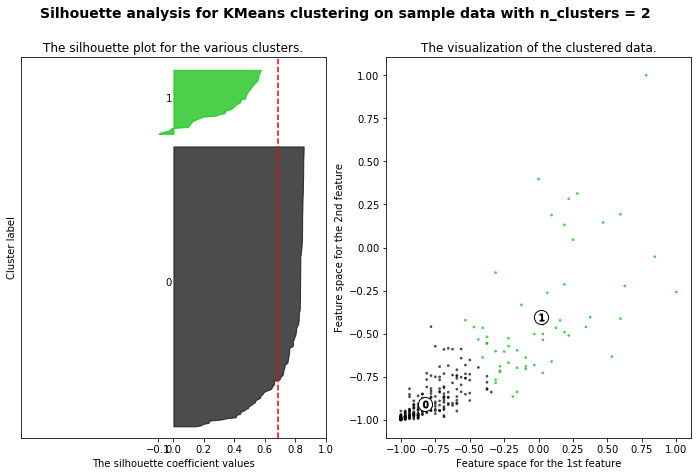

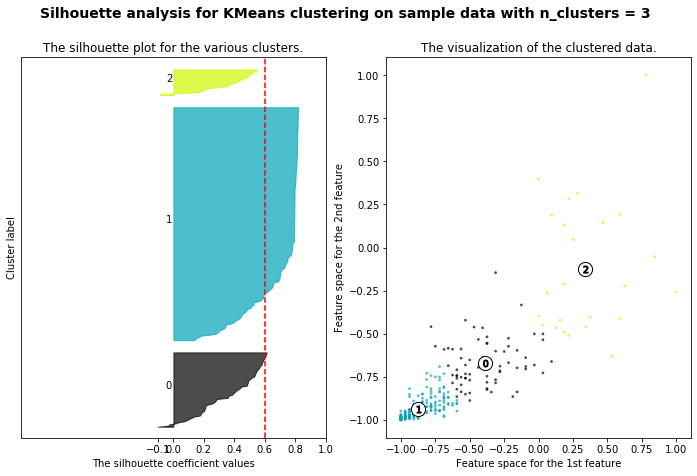

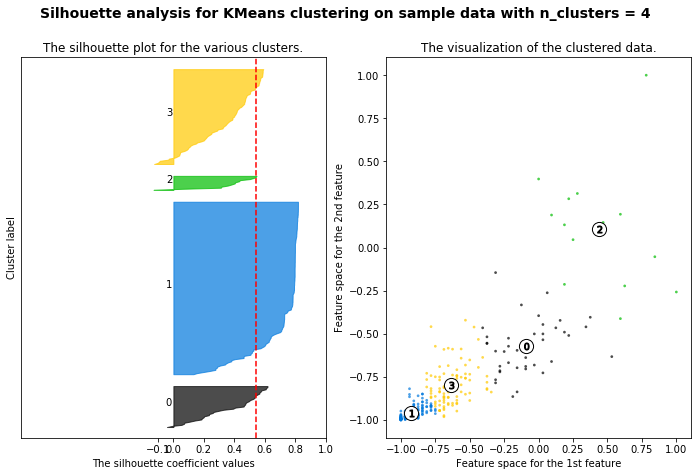

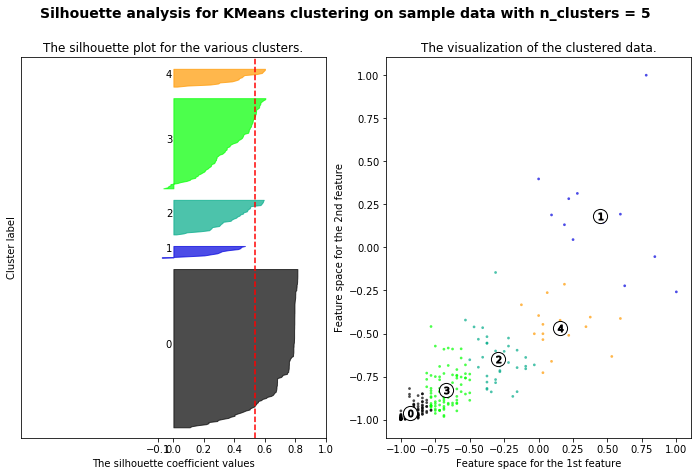

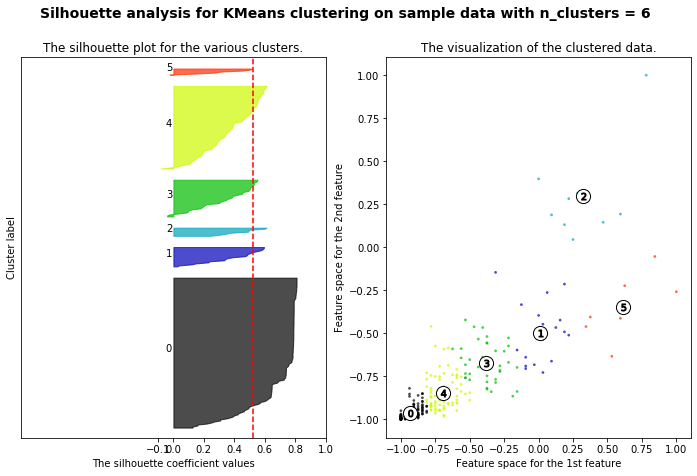

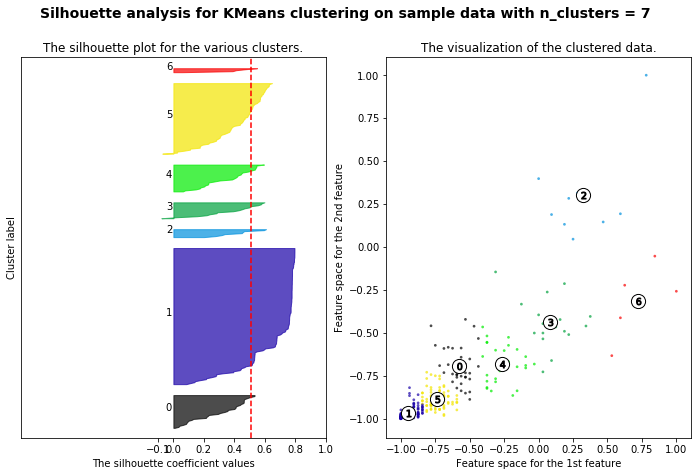

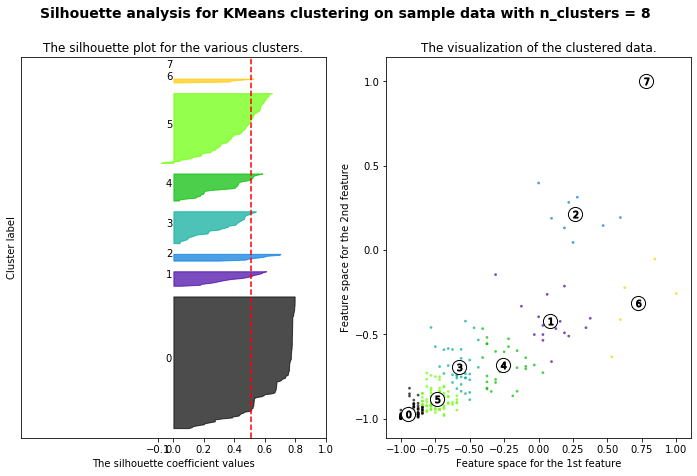

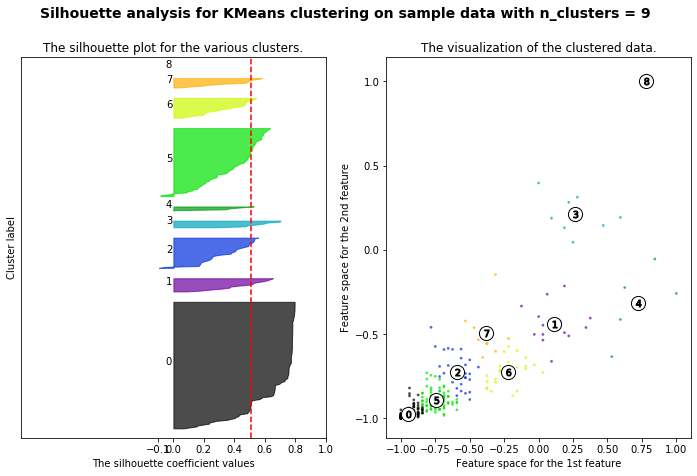

In [102]:
# run clustering

for n_clusters in range(2,10):

    clusterer = KMeans(init='k-means++', n_clusters=n_clusters, n_init = 100, random_state=10) # set seed
    cluster_labels = clusterer.fit_predict(data_matrix)
    silhouette_avg = silhouette_score(data_matrix, cluster_labels)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)    
    
    sample_silhouette_values = silhouette_samples(data_matrix, cluster_labels)
    
    #plot
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(12, 7)
    ax1.set_xlim([-1, 1])
    ax1.set_ylim([0, len(data_matrix) + (n_clusters + 1) * 10])
    
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(data_matrix[:, 0], data_matrix[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()
    


### Based on the silhouette score, we choose cluster, n_cluster = 4 as each of the cluster has higher than average silhouette score as marked by the red vertical line combined with the fact that it also has a high overall silhouette score

For n_clusters = 4 The average silhouette_score is : 0.5410133479076882


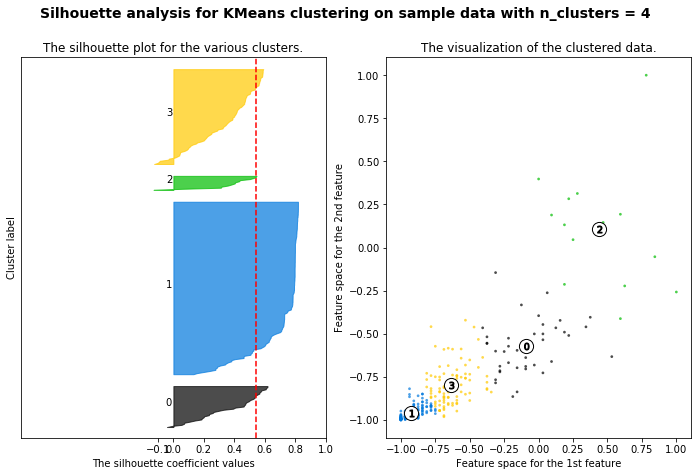

In [103]:
for n_clusters in range(4,5):
    # fit
    clusterer = KMeans(init='k-means++', n_clusters=n_clusters, n_init = 100, random_state=10) # set seed
    cluster_labels = clusterer.fit_predict(data_matrix)
    silhouette_avg = silhouette_score(data_matrix, cluster_labels)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)    
    
    sample_silhouette_values = silhouette_samples(data_matrix, cluster_labels)
    
    #plot
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(12, 7)
    ax1.set_xlim([-1, 1])
    ax1.set_ylim([0, len(data_matrix) + (n_clusters + 1) * 10])
    
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(data_matrix[:, 0], data_matrix[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()
    


### Cluster Analysis

From the plot, we can see that customers in label 1 correspond to (low purchase,low frequency shopper), 3 is (mid purchase,mid frequency shopper), 0 is (high purchase,high frequency shopper) and finally 2 is (very high purchase,very high frequency shopper)

In [145]:
# rename cluster labels to signal order

finaldf = pd.DataFrame(zip(list(maindf2.index),list(maindf2['frequency_visits']),list(maindf2['total_purchase']),
                list(cluster_labels)), columns=['sales_customer','frequency_visits','total_purchase','label'])

# reorder the labels
finaldf['label'] = finaldf['label'].apply(lambda x : 0 if x == 1 else (2 if x == 0 else(1 if x == 3 else 3)))

In [146]:
finaldf

,sales_customer,frequency_visits,total_purchase,label
0,1,1,24,0
1,2,3,14,0
2,6,17,234,1
3,7,8,227,1
4,8,5,124,0
...,...,...,...,...
298,719,3,18,0
299,720,2,11,0
300,722,1,5,0
301,724,7,207,1


## Requirement

2. Identify 1-1 product category association rules for each cluster if_bought_this_category -> likely_to_buy_this_category and evaluate them based on relevant metrics. Code libraries used should be limited to linear algebra and dataframe manipulation

In [141]:
# imports

import pandas as pd
import numpy as np
from itertools import combinations

In [147]:
df1 = pd.DataFrame(pd.read_csv('s2_transaction_data.csv'))
df2 = pd.DataFrame(pd.read_csv('s2_product_master.csv'))
df1 = df1.drop(columns = df1.columns[0])
# change dtype
df1.loc[:, 'sales_date_id'] = pd.to_datetime(df1.loc[:,'sales_date_id'], format = '%Y%m%d').copy()
df2 = df2.drop(columns = df2.columns[0])
maindf3 = df1.join(df2.set_index('product_id'), how = 'inner',on='sales_product')

# join with cluster output
maindf3 = maindf3.set_index('sales_customer').join(
    finaldf.set_index('sales_customer'), how = 'inner', on='sales_customer').copy()


In [155]:
maindf3 = maindf3.reset_index()

In [156]:
maindf3

,sales_customer,sales_receipt,sales_product,sales_date_id,product_lvl1_cat_desc,product_lvl2_cat_desc,frequency_visits,total_purchase,label
0,569,203722145,30763,2018-01-02,FoodCommodity,JarredFood,20,320,1
1,569,204158417,30763,2018-02-28,FoodCommodity,JarredFood,20,320,1
2,569,204370097,30763,2018-03-28,FoodCommodity,JarredFood,20,320,1
3,569,204875526,30763,2018-05-31,FoodCommodity,JarredFood,20,320,1
4,569,205427726,30763,2018-08-07,FoodCommodity,JarredFood,20,320,1
...,...,...,...,...,...,...,...,...,...
49995,679,205198999,97212,2018-07-11,Beverages,Water,1,1,0
49996,227,204457799,94997,2018-04-09,Alcohol,Wine,2,2,0
49997,227,204687758,6928,2018-05-08,Alcohol,Spirits,2,2,0
49998,560,204812642,92051,2018-05-23,FoodCommodity,InstantAndReadytoEat,1,1,0


### Using the apriori algorithm for market basket analysis

- However do not set any threshold, threshold setting will require some domain knowledge
- Output relevant metrics for the analysis, namely rule support, confidence and lift

In [157]:
# utils for apriori

def apriori(df, support = True, confidence = True, lift = True):
    """
    return a df with antecedents("if bought this category"), 
    consequents("likely_to_buy_this_category")
    """
    
    
    def generate_all_combi(df):
        unique_category = df.columns
        comb_ls = list(combinations(list(unique_category),2))
        # need to invert as well
        
        new_dict = {}
        antecedents = []
        consequents = []
        for i in range(len(comb_ls)):
            antecedents.append(comb_ls[i][0])
            consequents.append(comb_ls[i][1])
            antecedents.append(comb_ls[i][1])
            consequents.append(comb_ls[i][0])
        new_dict['antecedents'] = antecedents
        new_dict['consequents'] = consequents
        return pd.DataFrame(new_dict)

    def support(df, df1):
        # calculate the rule supports only , rule supports = (transaction containing rule)/total_transactions
        rule_dict = {}
        antecedents = list(df1['antecedents'])
        consequents = list(df1['consequents'])
        total_n = len(df) # total transactions
        for i in range(0,len(df1),2):
            rule_dict[(antecedents[i],consequents[i])] = len(df.loc[(df[antecedents[i]] > 0) & 
                                                                 (df[consequents[i]] >0)])/total_n
            
            rule_dict[(consequents[i],antecedents[i])] =  rule_dict[(antecedents[i],consequents[i])]

        support = [rule_dict[antecedents[i],consequents[i]] for i in range(len(df1))]
        df2 = df1.copy()
        df2['support'] = support  
        return df2
                
    
    def confidence(df, df1):
        # calculate the confidence, confidence (A=>B)  = (transactions involve both A and B)/(Transactions involving onlyA)
        rule_dict = {}
        antecedents = list(df1['antecedents'])
        consequents = list(df1['consequents'])
        
        for i in range(len(df1)):
            rule_dict[(antecedents[i],consequents[i])] = len(df.loc[(df[antecedents[i]] > 0) & 
                                                                 (df[consequents[i]] >0)])/len(df[df[antecedents[i]]>0])
        df2 = df1.copy()
        
        confidence = [rule_dict[(antecedents[i],consequents[i])] for i in range(len(df2))]
        df2['confidence'] = confidence
        
        return df2
            
    
    def lift(df,df1):

        lift_dict = {}
        support_dict = {}
        antecedents = list(df1['antecedents'])
        consequents = list(df1['consequents'])
        total_n = len(df)
        
        for i in range(len(df1)):
            if consequents[i] not in support_dict:
                support_dict[consequents[i]] =  len(df[df[consequents[i]] >0])/total_n
            confidence = len(df.loc[(df[antecedents[i]] > 0) &(df[consequents[i]] >0)])/len(df[df[antecedents[i]]>0])
            lift_dict[(antecedents[i], consequents[i])] = confidence/support_dict[consequents[i]]
        df2 = df1.copy()
        lift = [lift_dict[(antecedents[i],consequents[i])] for i in range(len(df2))]
        df2['lift'] = lift
        return df2
    
    res_ls = []
    df1 = generate_all_combi(df)
    if support:
        support_df = support(df,df1)
        res_ls.append(support_df)
    if confidence:
        confidence_df = confidence(df,df1)
        res_ls.append(confidence_df)
    if lift:
        lift_df = lift(df,df1)
        res_ls.append(lift_df)
        
    res_df = pd.concat(res_ls, axis = 1)
    return res_df
    
    
        

### Calculate association rules for all clusters

In [158]:
# data prep
maindf4 = maindf3[['sales_receipt', 'product_lvl2_cat_desc', 'label']].copy()

In [162]:
# results
res_dict = {}
for i in range(4):
    tempDF = maindf4[maindf4['label'] == i].copy()
    tempDF = pd.get_dummies(tempDF)
    tempDF = tempDF.groupby('sales_receipt').sum().drop('label', axis = 1).rename(lambda x:x.split('desc_')[1], axis = 1)
    res_dict['label {}'.format(i)] = apriori(tempDF)
    


#### Interpretation for strong association rule


In [163]:
# for cluster label 0
maindf5 = res_dict['label 0']
maindf5 = maindf5.loc[:,~maindf5.columns.duplicated()].copy()
maindf5[(maindf5['confidence'] > 0.8) & (maindf5['lift'] > 6) & (maindf5['support'] > 0.0045)]

,antecedents,consequents,support,confidence,lift
6362,HardVegetables,SoftVegetables,0.063636,0.833333,8.647799
7958,Mushrooms,SoftVegetables,0.023636,0.866667,8.993711


With high confidence and high lift, this tells us that softvegetablese are more frequently bought with HardVegatables and with mushrooms. Hence if a customer buys Hardvegetables, there is a 83% chance that he will buy soft vegetables, and SoftVegetables is 8.647799 times more likely to be bought by the customer who buys HardVegetables compared to the likelihood of its individual purchase (likelihood that softvegetables is included in a transaction).